<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Требуется инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Для выполнения задачи классификации выполним следующие шаги:**  
- лемматизируем текст и приведём к нижнему регистру
- очистим текст
- посчитаем tf-idf с учётом стоп-слов
- на подготовленных данных обучим модели логистической регрессии, градиентного бустинга и решающего дерева
- оценим качество предсказаний моделей метрикой f1 на обучающей и тестовой выборках
- выберем лучшую модель с метрикой f1 не менее 0.75

## Подготовка

In [21]:
#Импортируем сторонние библиотеки
import pandas as pd
import numpy as np
import nltk
import re
import warnings
import matplotlib.pyplot as plt
import spacy

#импортируем модули
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from pprint import pprint

from time import time

from catboost import (
    CatBoostClassifier,
    Pool)

warnings.filterwarnings('ignore')

In [22]:
spacy.cli.download('en_core_web_sm')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [23]:
data = pd.read_csv('/datasets/toxic_comments.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [24]:
%%time
#Лемматизируем и очищаем текст
lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatize_text(text):
    doc = lemmatizer(text.lower())
    lemm_text = " ".join([token.lemma_ for token in doc])
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

data['text'] = data['text'].apply(lemmatize_text)

CPU times: user 18min 28s, sys: 3.57 s, total: 18min 32s
Wall time: 18min 32s


> Готово, спасибо)

In [29]:
#Делим выборку на обучающую и тестовую в пропорции 1:1
data_train, data_test = train_test_split(data, test_size=0.1)
corpus_train = data_train['text'].values
features_train = data_train.drop(['Unnamed: 0', 'toxic'], axis=1)
corpus_test = data_test['text'].values
features_test = data_test.drop(['Unnamed: 0', 'toxic'], axis=1)
target_train = data_train['toxic']
target_test = data_test['toxic']

In [31]:
#Отдельно обучающий и валидационный сет для CatBoost
data_train_cat, data_valid_cat = train_test_split(data_train, test_size=0.1)
features_train_cat = data_train_cat.drop(['Unnamed: 0', 'toxic'], axis=1)
target_train_cat = data_train_cat['toxic']
features_valid_cat = data_valid_cat.drop(['Unnamed: 0', 'toxic'], axis=1)
target_valid_cat = data_valid_cat['toxic']

> Небольшой вопрос: если я пытаюсь перевести corpus_train = data_train['text'].values.astype('U') - ядро сразу умирает. Пытался перевести формат, т.к. в теоретической части есть подобный пример, но не объяснгяется зачем это нужно. Собсвенно вопросы: Для чего нужно приводить к Юникоду и нужно ли вообще, т.к. и без этого код работает (по крайней мере, у меня)). И второй: почему ядро-то умирает? Пока не удалил применение метода .astype('U') - несколько раз пробовал и ядро гибнет.

In [7]:
#Загружаем стоп-слова
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
#Создаём счетчик
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Считаем tf-idf, которую будем использовать в качестве признаков
tf_idf = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test) 

Данные подготовленны, можно приступать к обученю моделей

## Обучение

In [49]:
model_LR = LogisticRegression(class_weight='balanced', max_iter=800)
pipeline = Pipeline(
    [
        ("vect", count_tf_idf),
        ("clf", model_LR),
    ]
)
pipeline

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=800))])

In [50]:
parameter_grid = {
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "clf__C": (40, 80),
}

In [51]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    cv=3,
    scoring='f1',
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'clf__C': (40, 80), 'vect__ngram_range': ((1, 1), (1, 2))}


In [52]:
t0 = time()
random_search.fit(corpus_train, target_train)
print(f"Done in {time() - t0:.3f}s")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Done in 3442.522s


In [53]:
print("Best parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Best parameters combination found:
clf__C: 80
vect__ngram_range: (1, 2)


In [54]:
print(
    "F1 of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)

F1 of the best parameters using the inner CV of the random search: 0.791


In [ ]:
#model = LogisticRegression()
#model.set_params(**LR_best_params)
#model.fit(tf_idf, target_train) 
#predictions_test = model.predict(tf_idf_test)
#f1_score_test_logreg = f1_score(predictions_test, target_test)
#print(f'Метрика F1 для обучающей выборки для логистической регрессии равна {f1_score_train_logreg}')
#print(f'Метрика F1 для тесовой выборки для логистической регрессии равна {f1_score_test_logreg}')

In [ ]:
#model_cat = CatBoostClassifier()
#pipeline_cat = Pipeline(
#    [
#        ("vect", count_tf_idf),
#        ("clf", model_cat)
#    ]
#)
#pipeline_cat

In [ ]:
#parameter_grid_cat = {
#    "vect__ngram_range": ((1, 2)),
#    "clf__text_features": 'text'
#}

In [ ]:
#random_search_cat = RandomizedSearchCV(
#    estimator=pipeline_cat,
#    param_distributions=parameter_grid_cat,
#    cv=3,
#    scoring='f1',
#    verbose=1,
#)
#
#print("Performing grid search...")
#print("Hyperparameters to be evaluated:")
#pprint(parameter_grid_cat)

In [ ]:
#t0 = time()
#random_search_cat.fit(data_train, target_train)
#print(f"Done in {time() - t0:.3f}s")

In [8]:
text_features = ['text']
def fit_catboost(X_train, X_test, y_train, y_test, catboost_params={}, verbose=100):
    learn_pool = Pool(
        X_train, 
        y_train, 
        text_features=text_features,
        feature_names=list(X_train)
    )
    test_pool = Pool(
        X_test, 
        y_test, 
        text_features=text_features,
        feature_names=list(X_train)
    )
    
    catboost_default_params = {
        'iterations': 1000,
        'learning_rate': 0.03,
        'eval_metric': 'Accuracy',
    }
    
    catboost_default_params.update(catboost_params)
    
    model = CatBoostClassifier(**catboost_default_params)
    model.fit(learn_pool, eval_set=test_pool, verbose=verbose)

    return model

In [9]:
%%time
model = fit_catboost(features_train_cat, features_valid_cat, target_train_cat, target_valid_cat)

0:	learn: 0.9418872	test: 0.9474786	best: 0.9474786 (0)	total: 536ms	remaining: 8m 55s
100:	learn: 0.9511025	test: 0.9557788	best: 0.9559880 (90)	total: 49.7s	remaining: 7m 22s
200:	learn: 0.9538462	test: 0.9573132	best: 0.9573830 (193)	total: 1m 39s	remaining: 6m 36s
300:	learn: 0.9563728	test: 0.9582200	best: 0.9584292 (298)	total: 2m 30s	remaining: 5m 49s
400:	learn: 0.9580391	test: 0.9595452	best: 0.9596847 (388)	total: 3m 20s	remaining: 4m 59s
500:	learn: 0.9590312	test: 0.9595452	best: 0.9597545 (468)	total: 4m 10s	remaining: 4m 9s
600:	learn: 0.9597210	test: 0.9598242	best: 0.9598940 (529)	total: 4m 59s	remaining: 3m 18s
700:	learn: 0.9607053	test: 0.9601730	best: 0.9602427 (649)	total: 5m 48s	remaining: 2m 28s
800:	learn: 0.9615191	test: 0.9603125	best: 0.9605217 (793)	total: 6m 37s	remaining: 1m 38s
900:	learn: 0.9619686	test: 0.9601730	best: 0.9605217 (793)	total: 7m 26s	remaining: 49.1s
999:	learn: 0.9623949	test: 0.9601032	best: 0.9605217 (793)	total: 8m 15s	remaining: 0us


In [41]:
predictions_valid = model.predict(features_valid_cat)

In [46]:
predictions_train = model.predict(features_train_cat)

In [57]:
f1_score_cat = f1_score(target_valid_cat, predictions_valid)

In [48]:
f1_score(target_train_cat, predictions_train)

0.813804643380046

In [55]:
#%%time
##Обучим дерево решений, подберём лучшие гиперпараметры и проверим на тестовой выборке
#DTC = DecisionTreeClassifier()
#hyperparams = [{'max_depth': range(45, 100, 10),
#                'min_samples_split': [2, 3],
#                'class_weight': ['balanced'],
#                'min_samples_leaf': [1, 2]}]
#
#dtc_model = GridSearchCV(DTC, hyperparams, scoring='f1')
#dtc_model.fit(tf_idf, target_train)
#DTC_best_params = dtc_model.best_params_
#means = dtc_model.cv_results_['mean_test_score']
#stds = dtc_model.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, dtc_model.cv_results_['params']):
#    print("%0.6f for %r"% (mean, params))
#print(f'Лучшие параметры для логистической регрессии: {DTC_best_params}')
#
#f1_score_train_DTC = max(means)
f1_score_train_DTC = 0.63

In [ ]:
#model = DecisionTreeClassifier()
#model.set_params(**DTC_best_params)
#model.fit(tf_idf, target_train)
#predictions_test = model.predict(tf_idf_test)
#f1_score_test_DTC = f1_score(predictions_test, target_test)
#print(f'Метрика F1 для обучающей выборки для логистической регрессии равна {f1_score_train_DTC}')
#print(f'Метрика F1 для тесовой выборки для логистической регрессии равна {f1_score_test_DTC}')

Text(0.5, 1.0, 'F1 на обучающей выборке')

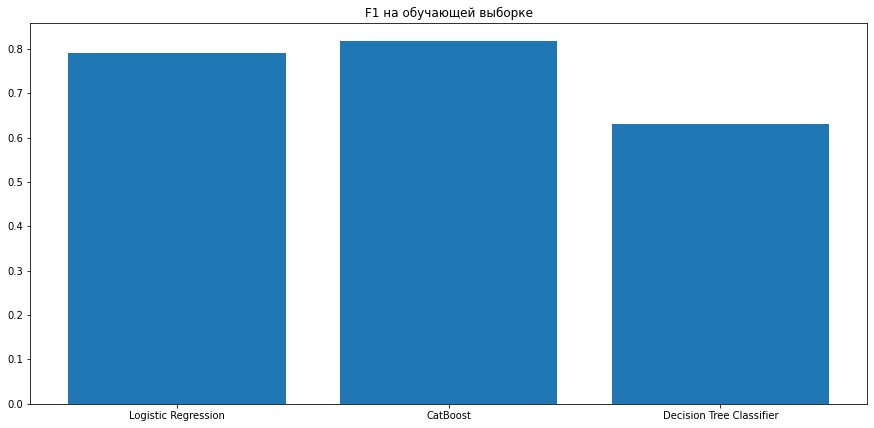

In [59]:
f1_train = [random_search.best_score_, f1_score_cat, f1_score_train_DTC]
models = ['Logistic Regression', 'CatBoost', 'Decision Tree Classifier']
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1.bar(models, f1_train)
ax1.set_title('F1 на обучающей выборке')

CatBoost на валидационной выборке показала лучшие результаты метрики f1, протестируем её на тестовой выборке.

In [60]:
predictions_test = model.predict(features_test)
f1_score(target_test, predictions_test)

0.810038340885326

## Выводы

Для выполнения задачи классификации было принято решение использовать преобразованные при помощи tf-idf данные.  
На основании полученных признаков были обучены и настроены гиперпараметры нескольких моделей: логистическая регрессия, градиентный бустинг и дерево решений. По итогу модели обладают следующими качествами:  

Логистическая регрессия.  
- длительное время подбора гиперпараметров: даже при переборе нескольких гиперпараметров в небольшом диапазоне, работа кода занимает более двух часов
- удовлетворительная метрика f1 (0.79) 

Градиентный бустинг CatBoost
- бытрое время обучения без перебора гиперпараметров: не более 10 минут
- лучшая метрика f1 (0.81)  

Дерево решений
- удовлетворительное время подбора гиперпараметров через GridSearch (около часа)
- неудовлетворительная метрика f1 (0.63)
  
**Задача выполненна: лучшая модель, подходящая по условиям - градиентный бустинг CatBoost**